In [6]:
import os
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

# Define folder path
base_folder = "./IDP Group A"

# Define wavelength list (450 nm to 950 nm in 20 nm steps)
wavelengths = list(range(450, 951, 20))

# Define subfolders
sample_folders = [f"d{i}" for i in range(1, 15)]  # d1 to d14
dark_folder = "dark"
white_folder = "white"
reference_folder = "reference image"


# Load white and dark images
def load_cube(folder_path):
    tif_files = [f for f in os.listdir(folder_path) if f.lower().endswith(".tif")]
    tif_files.sort()

    cube = []
    for tif_file in tif_files:
        tif_path = os.path.join(folder_path, tif_file)
        tif = tiff.imread(tif_path)
        cube.append(tif)

    cube = np.array(cube)

    return cube


# Load dark and white reference cubes
dark_cube = load_cube(os.path.join(base_folder, dark_folder))
white_cube = load_cube(os.path.join(base_folder, white_folder))
reference_cube = load_cube(os.path.join(base_folder, reference_folder))


# Avoid division by zero
denominator = white_cube - dark_cube
denominator[denominator == 0] = 1e-6

# Load and compute reflectance for each sample
reflectance_cubes = {}

for folder in sample_folders:
    sample_cube = load_cube(os.path.join(base_folder, folder))
    R = (sample_cube - dark_cube) / denominator
    reflectance_cubes[folder] = R  # Shape: (bands, height, width)

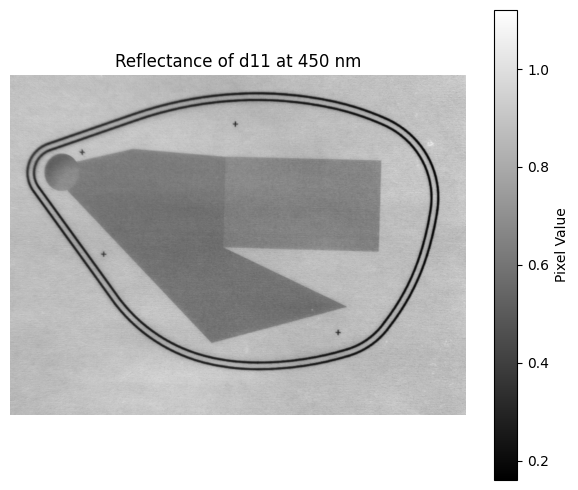

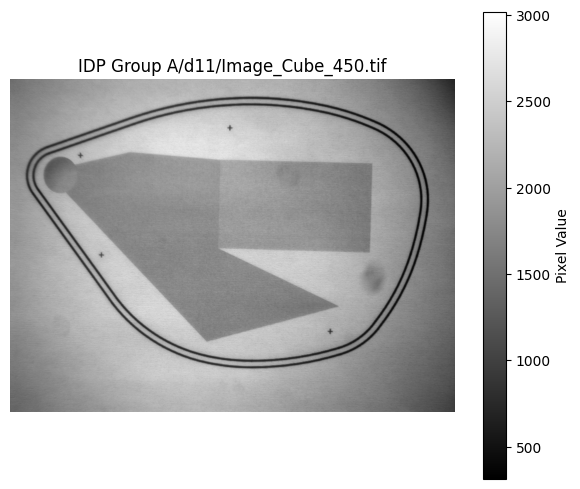

In [7]:
# R_d1 = reflectance_cubes["d1"] # Example: Access reflectance cube for d1


def plot_image(image, title=""):
    # Plot the image
    plt.figure(figsize=(6, 5))
    plt.imshow(image, cmap="gray")
    plt.colorbar(label="Pixel Value")
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


def plot_example_reflectance(reflectance_cubes, sample_name, wavelength):
    # Get reflectance cube
    R = reflectance_cubes[sample_name]

    # Extract 2D image at selected wavelength
    reflectance_image = R[wavelengths.index(wavelength), :, :]
    title = f"Reflectance of {sample_name} at {wavelength} nm"

    plot_image(reflectance_image, title)


def plot_original_tif(tif_path):
    image = tiff.imread(tif_path)

    plot_image(image, tif_path)


def get_example_reflectance(reflectance_cubes, sample_name, wavelength):
    # Get reflectance cube
    R = reflectance_cubes[sample_name]

    # Extract 2D image at selected wavelength
    reflectance_image = R[wavelengths.index(wavelength), :, :]

    return reflectance_image


plot_example_reflectance(reflectance_cubes, "d11", 450)
plot_original_tif("IDP Group A/d11/Image_Cube_450.tif")

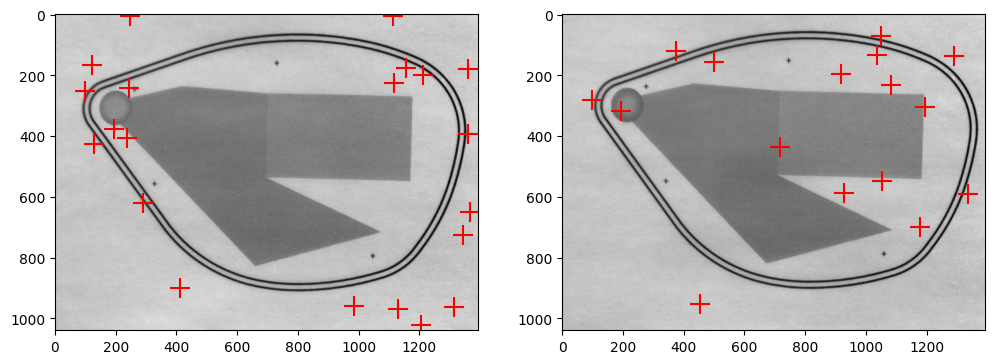

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def detect_alignment_points(img):
    # 1. Convert to grayscale (if not already)
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()

    # --- FIX: normalise to [0,255] and convert to uint8 ---
    gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)
    gray = gray.astype(np.uint8)

    # 2. Enhance contrast
    gray = cv2.equalizeHist(gray)

    # 3. Adaptive threshold
    thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 51, -5
    )

    # 4. Morphological cleaning
    kernel = np.ones((3, 3), np.uint8)
    clean = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    # 5. Invert if "+" is dark
    if np.mean(clean) > 127:
        clean = cv2.bitwise_not(clean)

    # 6. Connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(clean)

    # 7. Filter "+" candidates
    candidates = []
    for i in range(1, num_labels):
        x, y, w, h, area = stats[i]
        aspect_ratio = w / h if h != 0 else 0
        if 0.6 < aspect_ratio < 1.4 and 50 < area < 55:
            candidates.append(centroids[i])

    candidates = np.array(candidates)

    # 8. Sort points (top-to-bottom, left-to-right)
    if len(candidates) == 4:
        sorted_points = candidates[np.lexsort((candidates[:, 0], candidates[:, 1]))]
    else:
        sorted_points = candidates

    return sorted_points, clean


# Example usage
reflectance_image_1 = reflectance_cubes["d1"][wavelengths.index(450), :, :]
reflectance_image_2 = reflectance_cubes["d2"][wavelengths.index(450), :, :]

pts1, mask1 = detect_alignment_points(reflectance_image_1)
pts2, mask2 = detect_alignment_points(reflectance_image_2)

# --- Corrected plotting section ---
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(reflectance_image_1, cmap="gray")
plt.scatter(pts1[:, 0], pts1[:, 1], c="r", marker="+", s=200)
# plt.title('Image 1 with Detected "+" Points')

plt.subplot(1, 2, 2)
plt.imshow(reflectance_image_2, cmap="gray")
plt.scatter(pts2[:, 0], pts2[:, 1], c="r", marker="+", s=200)
# plt.title('Image 2 with Detected "+" Points')
plt.show()

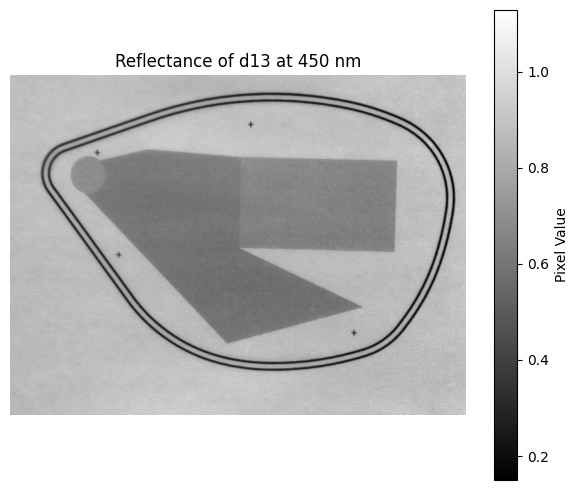

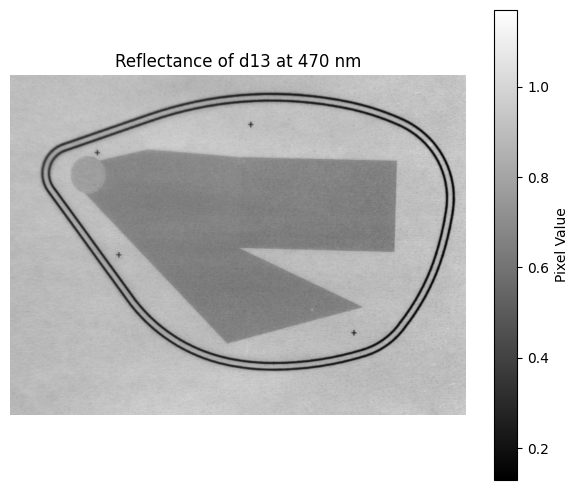

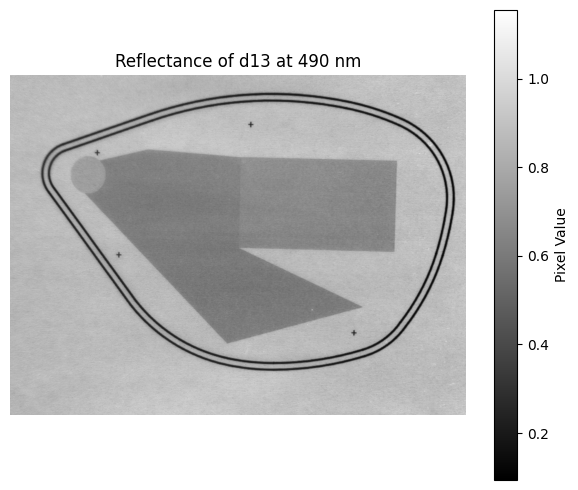

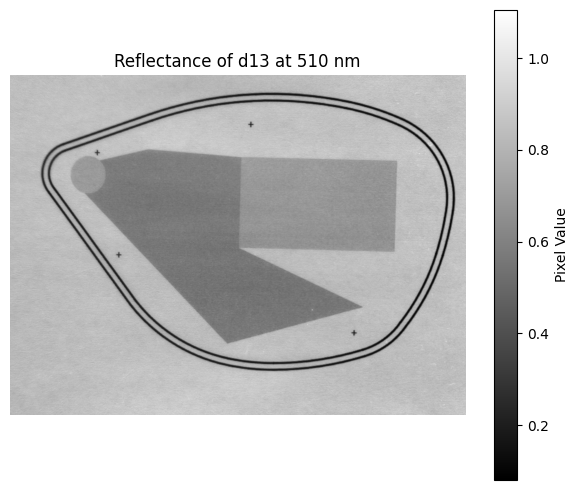

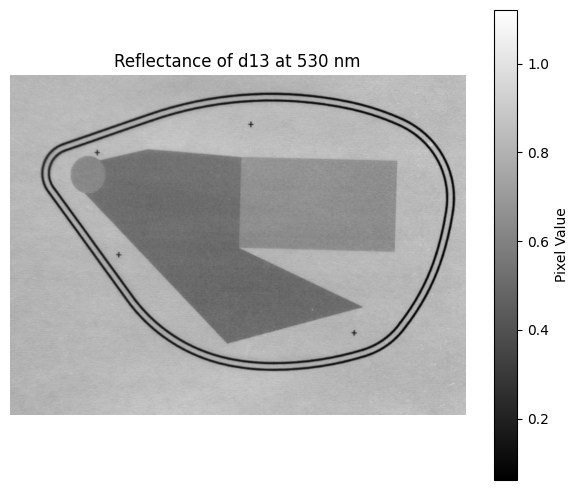

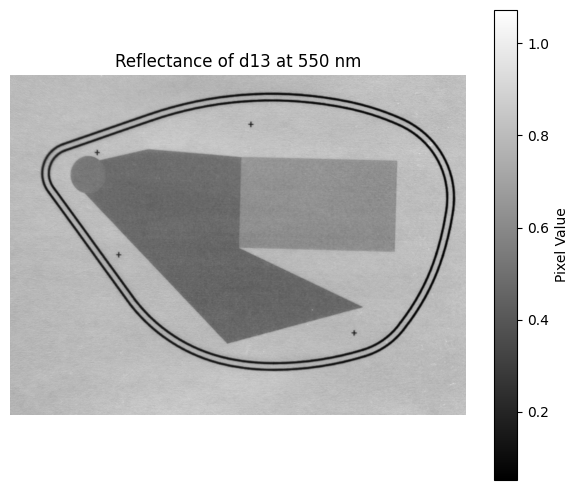

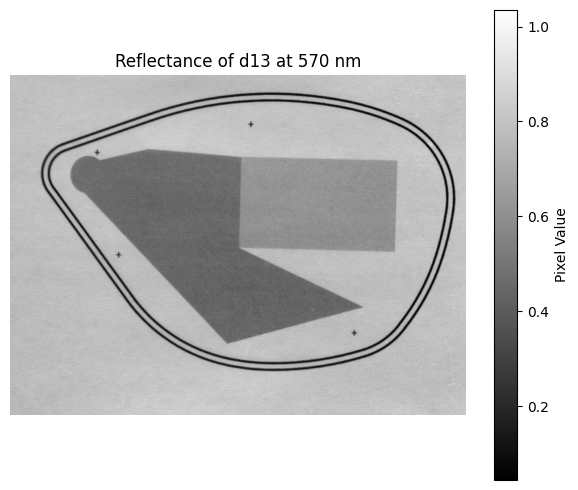

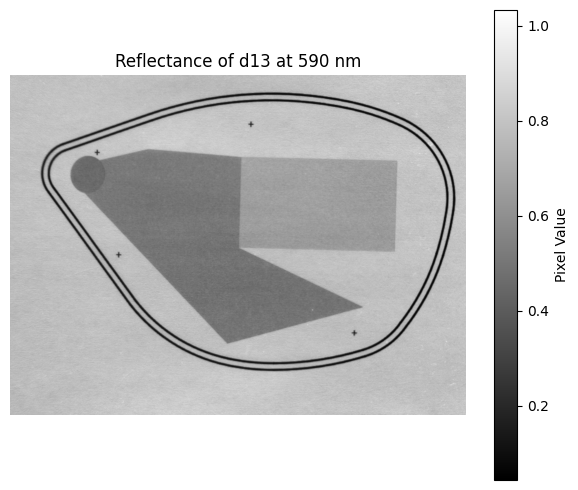

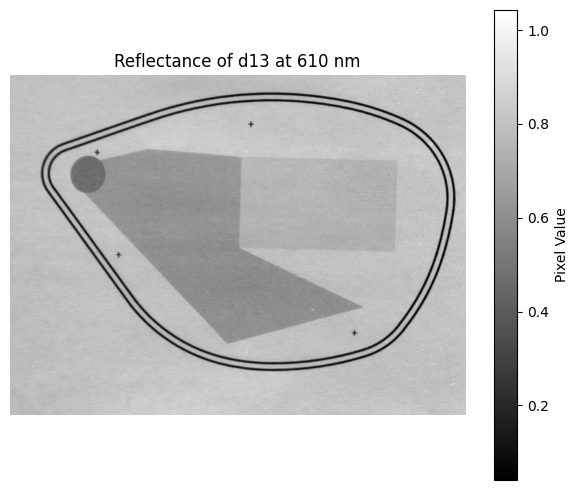

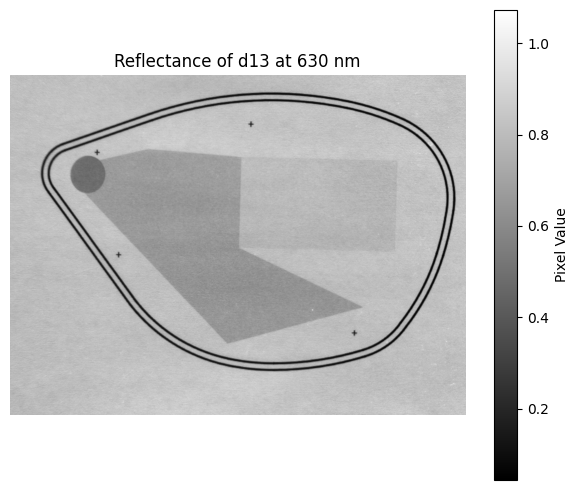

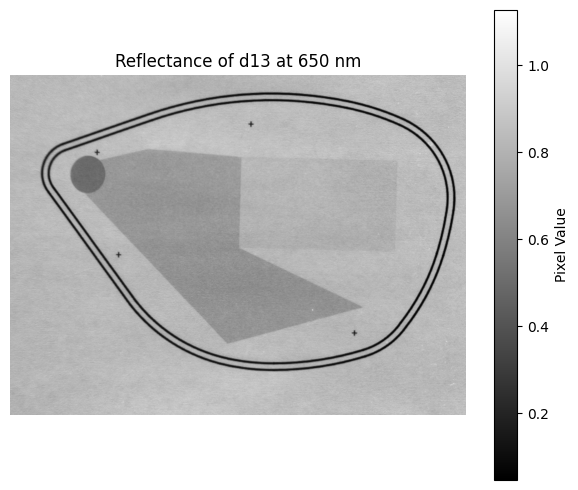

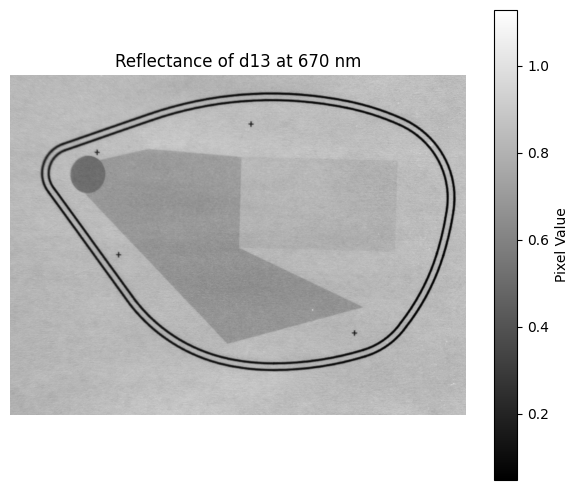

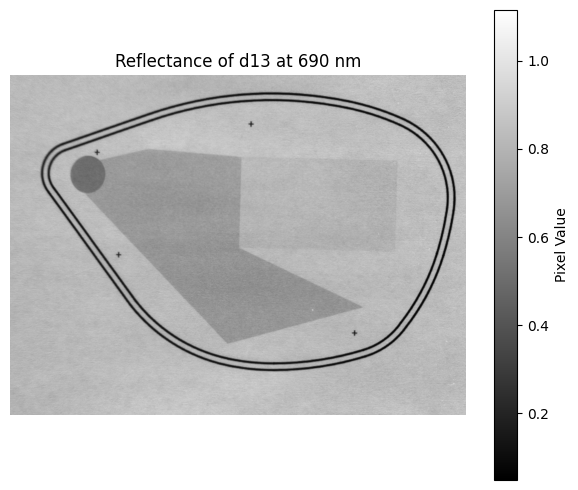

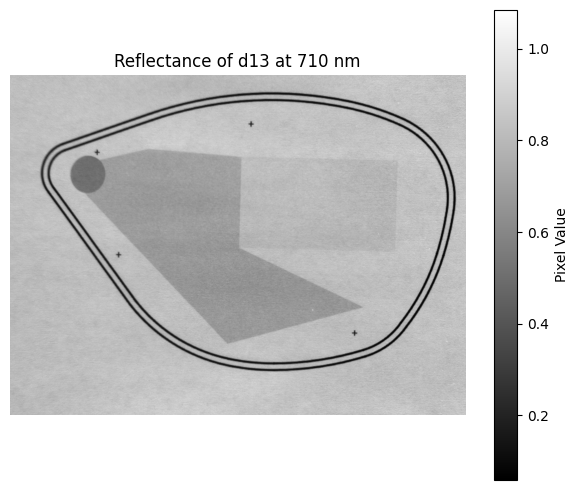

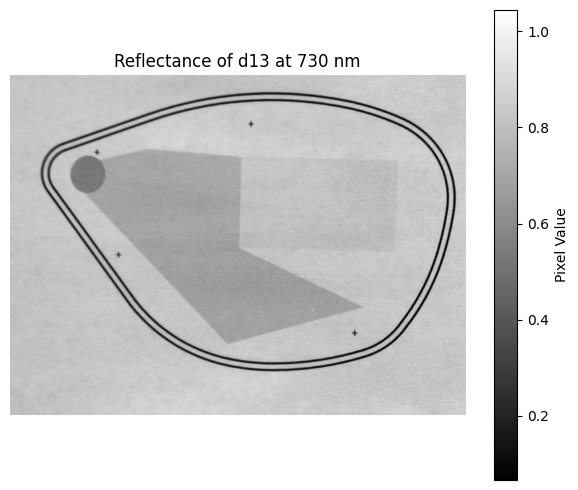

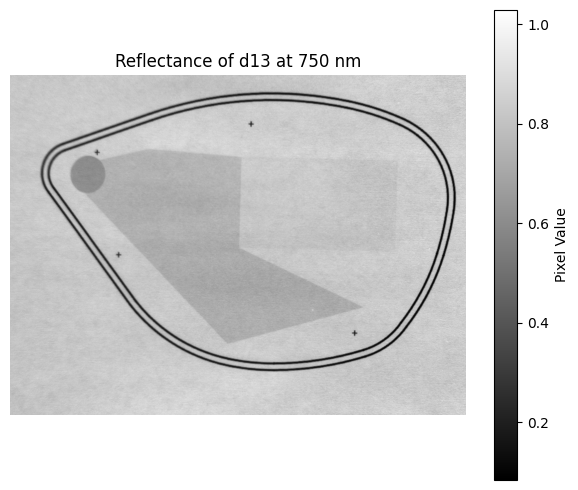

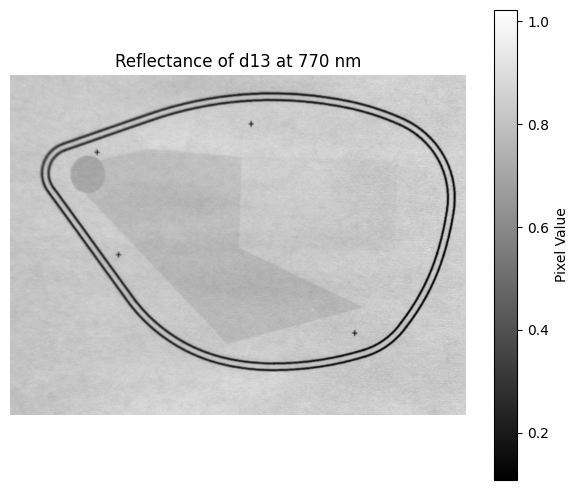

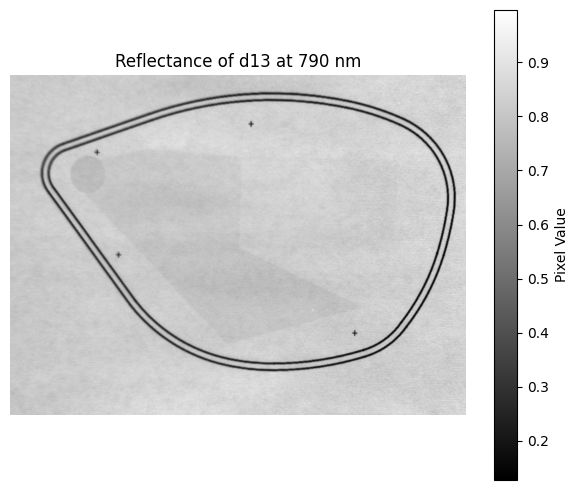

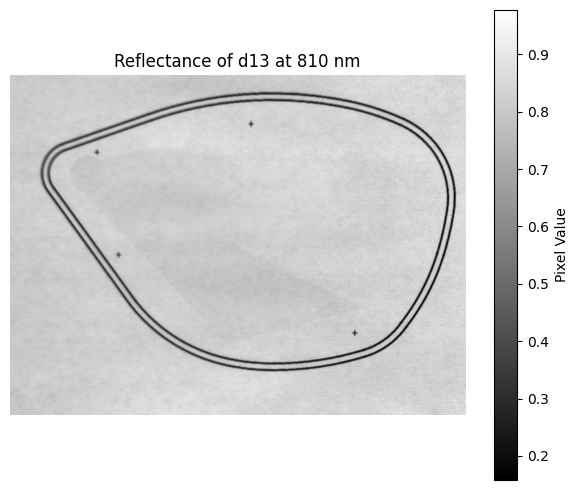

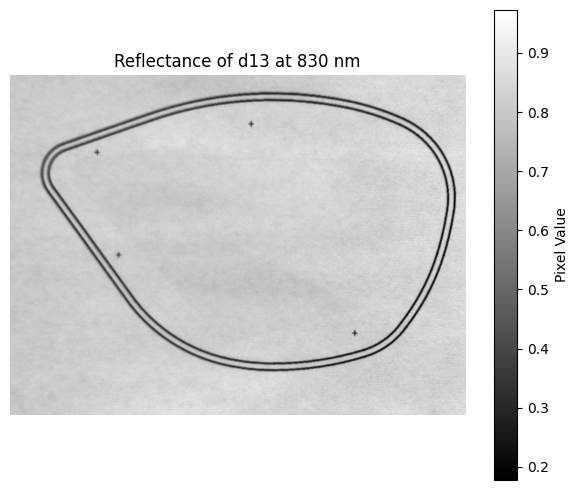

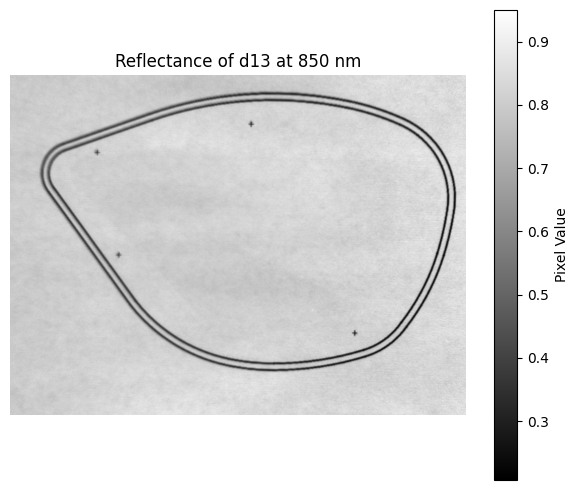

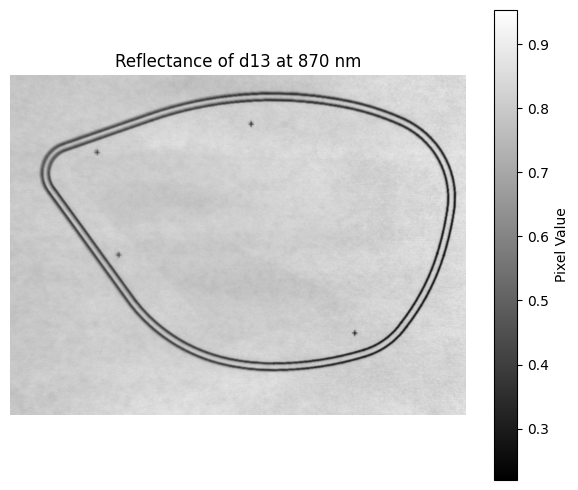

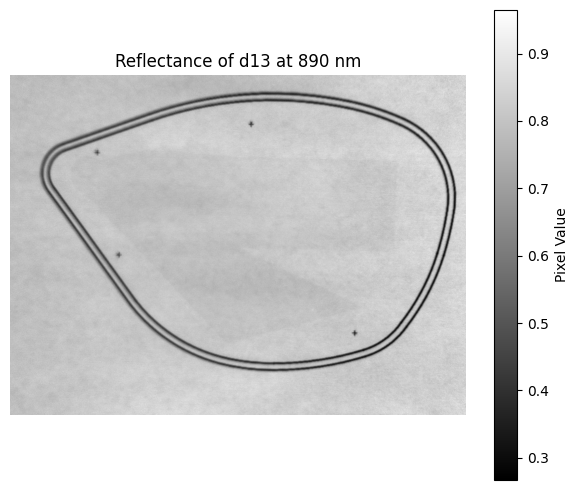

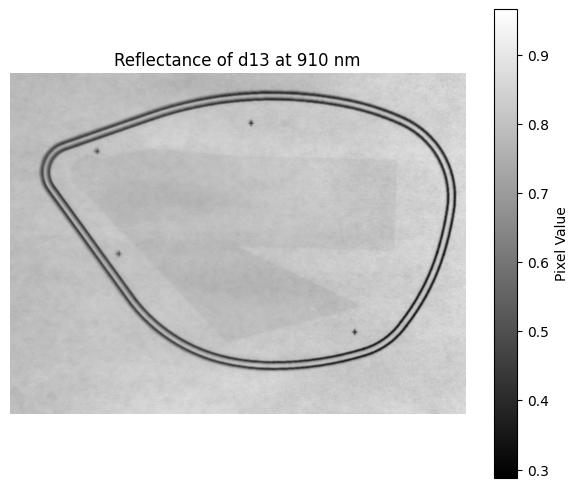

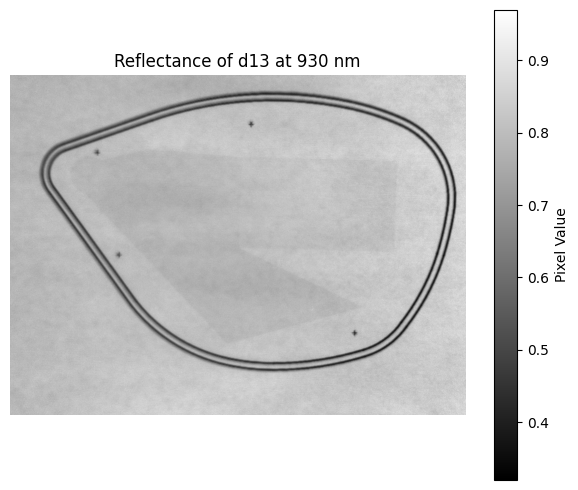

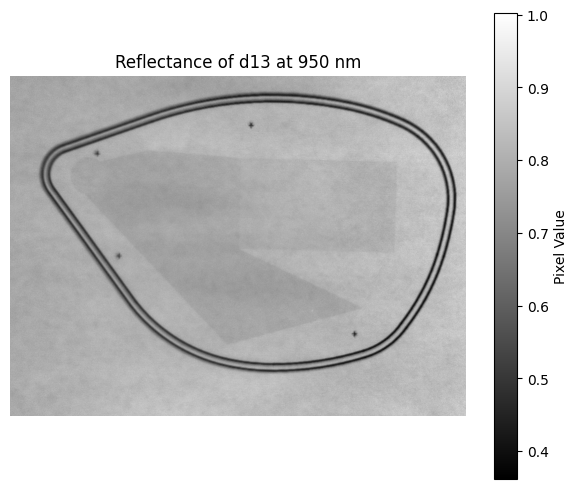

In [9]:
for i in wavelengths:
    plot_example_reflectance(reflectance_cubes, "d13", i)

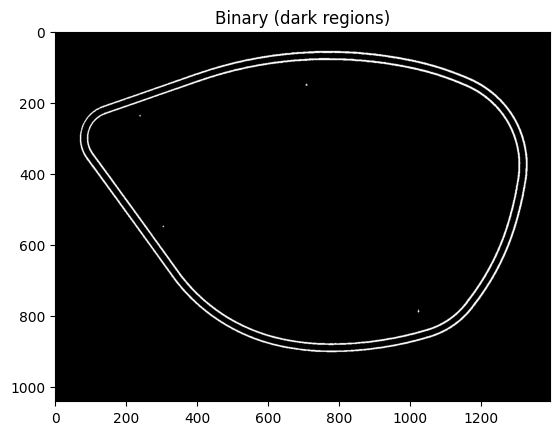


Detected 0 dots
Positions: []


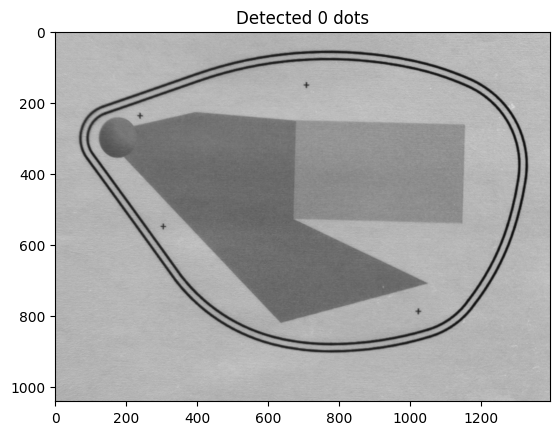

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

gray = get_example_reflectance(reflectance_cubes, "d12", 550)
gray_norm = gray / np.max(gray)
gray_norm = (gray_norm * 255).astype(np.uint8)
_, binary = cv2.threshold(gray_norm, 60, 255, cv2.THRESH_BINARY_INV)

plt.imshow(binary, cmap="gray")
plt.title("Binary (dark regions)")
plt.show()

# Find contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find small contours (the dots)
dot_centers = []
for contour in contours:
    area = cv2.contourArea(contour)
    if 5 < area < 200:  # Adjust based on dot size
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            dot_centers.append((cx, cy))
            print(f"Dot at ({cx}, {cy}), area: {area:.1f}")

print(f"\nDetected {len(dot_centers)} dots")
print(f"Positions: {dot_centers}")

# Visualize
result = cv2.cvtColor(gray_norm, cv2.COLOR_GRAY2BGR)
for i, (cx, cy) in enumerate(dot_centers):
    cv2.circle(result, (cx, cy), 10, (0, 255, 0), 2)
    cv2.putText(
        result, str(i + 1), (cx + 15, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2
    )

plt.imshow(result)
plt.title(f"Detected {len(dot_centers)} dots")
plt.show()

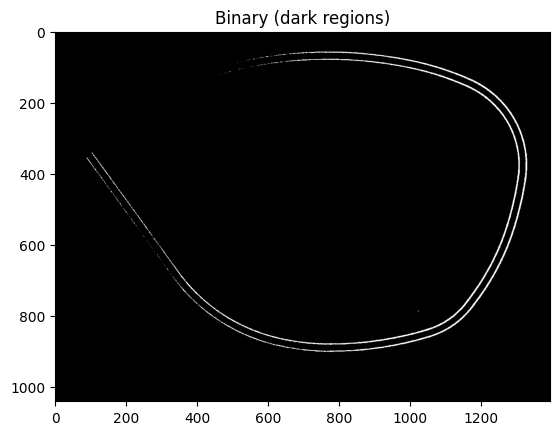

Dot at (651, 887), area: 85.5
Dot at (612, 879), area: 18.0
Dot at (453, 808), area: 25.5
Dot at (425, 787), area: 65.5
Dot at (393, 760), area: 16.5
Dot at (376, 743), area: 15.5
Dot at (360, 726), area: 29.5
Dot at (301, 613), area: 8.0
Dot at (279, 584), area: 5.5
Dot at (267, 567), area: 12.5
Dot at (254, 549), area: 23.5
Dot at (232, 519), area: 41.5
Dot at (196, 468), area: 56.5
Dot at (131, 413), area: 8.0
Dot at (112, 388), area: 8.5
Dot at (97, 367), area: 27.5
Dot at (140, 392), area: 129.5
Dot at (621, 88), area: 7.5
Dot at (644, 65), area: 7.0
Dot at (671, 62), area: 8.0

Detected 20 dots
Positions: [(651, 887), (612, 879), (453, 808), (425, 787), (393, 760), (376, 743), (360, 726), (301, 613), (279, 584), (267, 567), (254, 549), (232, 519), (196, 468), (131, 413), (112, 388), (97, 367), (140, 392), (621, 88), (644, 65), (671, 62)]


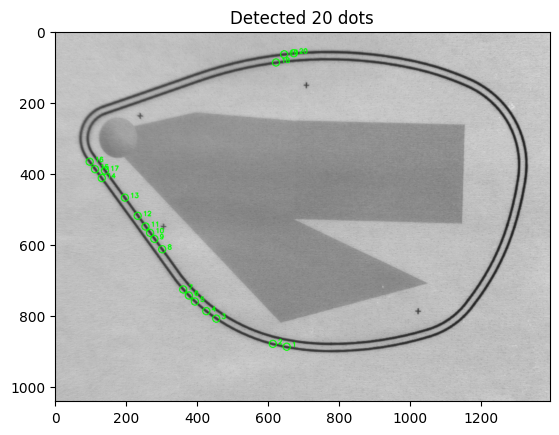

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

gray = get_example_reflectance(reflectance_cubes, "d12", 470)
gray_norm = gray / np.max(gray)
gray_norm = (gray_norm * 255).astype(np.uint8)
_, binary = cv2.threshold(gray_norm, 60, 255, cv2.THRESH_BINARY_INV)

plt.imshow(binary, cmap="gray")
plt.title("Binary (dark regions)")
plt.show()

# Find contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find small contours (the dots)
dot_centers = []
for contour in contours:
    area = cv2.contourArea(contour)
    if 5 < area < 200:  # Adjust based on dot size
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            dot_centers.append((cx, cy))
            print(f"Dot at ({cx}, {cy}), area: {area:.1f}")

print(f"\nDetected {len(dot_centers)} dots")
print(f"Positions: {dot_centers}")

# Visualize
result = cv2.cvtColor(gray_norm, cv2.COLOR_GRAY2BGR)
for i, (cx, cy) in enumerate(dot_centers):
    cv2.circle(result, (cx, cy), 10, (0, 255, 0), 2)
    cv2.putText(
        result, str(i + 1), (cx + 15, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2
    )

plt.imshow(result)
plt.title(f"Detected {len(dot_centers)} dots")
plt.show()